# Part of Speech Tagging

Part of Speech Tagging (POS) is the process of assigning a part of speech to a word. By doing so, we will learn the following: 

    1. Markov Chains

    2. Hidden Markov Models

    3. Viterbi algorithm

Here is a concrete example:

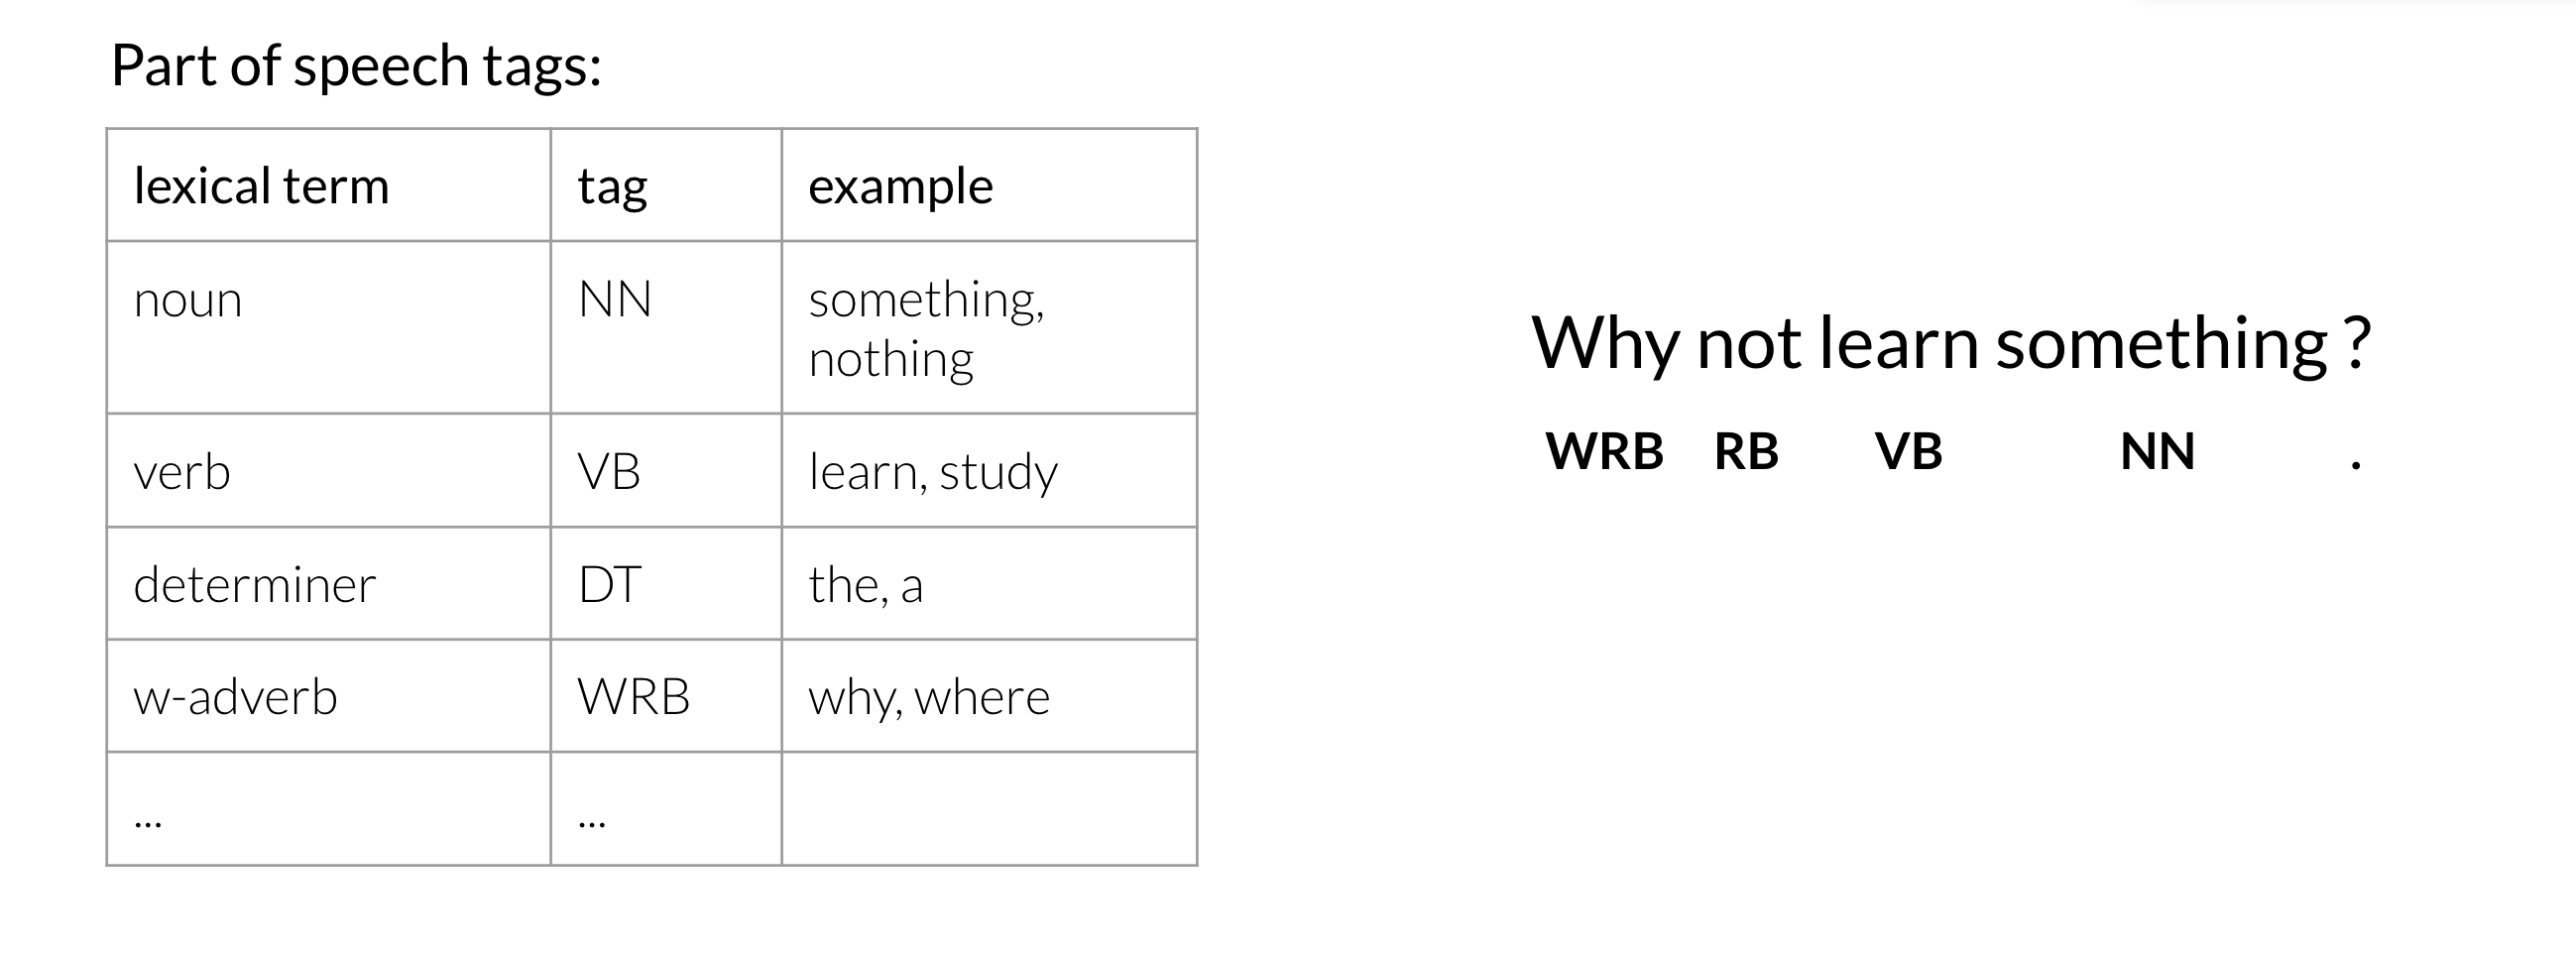

We can use part of speech tagging for: 

    Identifying named entities

    Speech recognition

    Coreference Resolution

 We can use the probabilities of POS tags happening near one another to come up with the most reasonable output.


# Parts-of-Speech Tagging - First Steps: Working with text files, Creating a Vocabulary and Handling Unknown Words

We will also learn how to:
 
- read text files
- work with defaultdict
- work with string data
 

In [1]:
import string
from collections import defaultdict

### Read Text Data

We will be working on `wall street journal` dataset 

Link to the datast: https://www.kaggle.com/datasets/stephgraban/wall-street-journal-articles-20142020

In [2]:
# Read lines from 'wall_street.pos' file and save them into the 'lines' variable

with open("./file/wall_street.pos", 'r') as file:
    line = file.readlines()

In [3]:
# To check the contents of the dataset we can print the first 5 lines:

print("\t\tWord", "\tTag\n")

for i in range(5):
    print(f'Line Number: {i+1}: {line[i]}')

		Word 	Tag

Line Number: 1: In	IN

Line Number: 2: an	DT

Line Number: 3: Oct.	NNP

Line Number: 4: 19	CD

Line Number: 5: review	NN



In [5]:
line[5]

'of\tIN\n'

Indeed there is a tab between the word and the tag and a newline at the end of each line.

### Creating a vocabulary

Now that we understand how the dataset is structured, we will create a vocabulary out of it. A vocabulary is made up of every word that appeared at least 2 times in the dataset. 
For this, follow these steps:
- Get only the words from the dataset
- Use a defaultdict to count the number of times each word appears
- Filter the dict to only include words that appeared at least 2 times
- Create a list out of the filtered dict
- Sort the list

For step 1 we can use the fact that every word and tag are separated by a tab and that words always come first. Using list comprehension the words list can be created like this:


In [8]:
# Get the words from each line in the dataset
words = [l.split('\t')[0] for l in line]

`defaultdicts`: It is a special kind of dictionaries that **return the "zero" value of a type if you try to access a key that does not exist**.

Since we want the frequencies of words, we should define the defaultdict with a type of int. 

In [9]:
# Define defaultdict of type 'int'

freq = defaultdict(int)

# Count frequency of ocurrence for each word in the dataset
for word in words:
    freq[word] += 1

Filtering the `freq` dictionary can be done using list comprehensions

We should filter out words that appeared only once and also words that are just a newline character:

In [12]:
# Create the vocabulary by filtering the 'freq' dictionary
vocab = [ k for k, v in freq.items() if v > 1 and k != "\n" ]


In [15]:
# Sort the vocabulary 
vocab.sort()

# Print some random values of the vocabulary
for i in range(2000, 2010):
    print(vocab[i])

ARE
ARTICLE
AS
ASCAP
ASSETS
ASSOCIATION
AST
AT&T
AUS
AVX


## Processing new text sources

### Dealing with unknown words

Now that we have a vocabulary, we will use it when processing new text sources. **A new text will have words that do not appear in the current vocabulary**. To tackle this, we can simply classify each new word as an unknown one, but it can be done by creating a function that tries to classify the type of each unknown word and assign it a corresponding `unknown token`. 

This function will do the following checks and return an appropriate token:

   - Check if the unknown word contains any character that is a digit 
       - return `--unk_digit--`
   - Check if the unknown word contains any punctuation character 
       - return `--unk_punct--`
   - Check if the unknown word contains any upper-case character 
       - return `--unk_upper--`
   - Check if the unknown word ends with a suffix that could indicate it is a noun, verb, adjective or adverb 
        - return `--unk_noun--`, `--unk_verb--`, `--unk_adj--`, `--unk_adv--` respectively

If a word fails to fall under any condition then its token will be a plain `--unk--`. The conditions will be evaluated in the same order as listed here. So if a word contains a punctuation character but does not contain digits, it will fall under the second condition. To achieve this behaviour some if/elif statements can be used along with early returns. 

This function is implemented next. Notice that the `any()` function is being heavily used. It returns `True` if at least one of the cases it evaluates is `True`.

In [16]:
def assign_unk(word):

    # Punctuation characters
    # Try printing them out in a new cell!
    punct = set(string.punctuation)

    # Suffixes
    noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
    verb_suffix = ["ate", "ify", "ise", "ize"]
    adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
    adv_suffix = ["ward", "wards", "wise"]

    # For digits
    if any(char.isdigit() for char in word):
        return '--unk_digit--'
    
    # for punctuation character
    elif any(char in punct for char in word):
        return '--unk_punct--'
    
    # For upper case character
    elif any(char.isupper() for char in word):
        return '--unk_upper--'


    # For word ends with any noun suffix
    elif any(word.endswith(suffix) for suffix in noun_suffix):
        return '--unk_noun--'
    
    # For word ends with any verb suffix
    elif any(word.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"
    
    # For word ends with any adjective suffix
    elif any(word.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"
    
    # For word ends with any adverb suffix
    elif any(word.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"
    

    # If none of the previous criteria is met, return plain unknown
    return "--unk--"
    

A POS tagger will always encounter words that are not within the vocabulary that is being used. By augmenting the dataset to include these `unknown word tokens` you are helping the tagger to have a better idea of the appropriate tag for these words. 

Now we will create a function that correct tag for particular word takes special considerations for new word. 

This function should check if a line is empty and if so, it should return a placeholder word and tag, `--n--` and `--s--` respectively. 

If not, it should process the line to return the correct word and tag pair, considering if a word is unknown in which scenario the function `assign_unk()` should be used.


In [17]:
def get_word_tag(line, vocab):
    if not line.split():
        tag = '--s--'
        word = '--n--'

    else:
        # Split line to separate word and tag
        word, tag = line.split()
        # Check if word is not in vocabulary
        if word not in vocab:
            # handle unknown word
            tag = assign_unk(word)

    return word, tag

In [18]:
# let's check the function

get_word_tag('\n', vocab)

('--n--', '--s--')

Since this line only includes a newline character it returns a placeholder word and tag.

In [19]:
get_word_tag('In\tIN\n', vocab)

('In', 'IN')

In [20]:
get_word_tag('tardigrade\tNN\n', vocab)

('tardigrade', '--unk--')

This line includes a noun that is not present in the vocabulary.

The assign_unk function fails to detect that it is a noun so it returns an unknown token.


In [21]:
get_word_tag('scrutinize\tVB\n', vocab)

('scrutinize', '--unk_verb--')

This line includes a verb that is not present in the vocabulary.

In this case the assign_unk is able to detect that it is a verb so it returns an unknown verb token.

